In [4]:
import pandas as pd
import requests
import json
from pandas import json_normalize
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [5]:
def get_GD_data(url):
  
  #buscando dados da API#######
  #Buscando com várias requisições
  df_aneel = pd.DataFrame()
  #dados = pd.DataFrame()
  
  offset = 0
  while True:
        url_base = url   
        #inserir parametro limit para definir quantidade de linhas acessada
        #a cada requisição à API (Valor máximo de 32000 de acordo com a documentação) 
        limit = 32000
        url_x = url_base + '&offset=' + str(offset) + '&limit=' + str(limit)
        #fazendo o request da web page e retornando um objeto json
        response = requests.get(url_x).json()
        r = json.dumps(response)
        #converse a str json para py dict 
        loaded_r = json.loads(r)
        #print(loaded_r)
        total_data_rows = loaded_r['result']['total']
        #busca a tabela de dados desejada
        dados = json_normalize(loaded_r['result']['records'])
        #dados = pd.DataFrame(loaded_r['result']['records'])
        df_aneel = pd.concat([df_aneel, dados])
        offset += 32000
        #print(offset, total_data_rows)
        if offset >= total_data_rows:
          #print('estou dentro do if')

          break
        
  
  
  
  
  
  
  
  #filtra as colunas
  dados_aneel = df_aneel.loc[:, ['DatGeracaoConjuntoDados',
                              'SigAgente', 'DscClasseConsumo', 
                              'DscClasseConsumo', 'CodSubGrupoTarifario', 
                              'DscSubGrupoTarifario', 'SigUF', 'NomRegiao', 
                              'NomMunicipio', 'SigTipoConsumidor', 'NumCPFCNPJ',
                              'SigModalidadeEmpreendimento', 'SigTipoGeracao', 
                              'DscPorte', 'NumCoordNEmpreendimento', 'NumCoordEEmpreendimento',
                              'MdaPotenciaInstaladaKW','DthAtualizaCadastralEmpreend']]
  #buscas as linhas referentes a geração no RN
  #dados_aneel = dados_aneel.loc[dados_aneel.SigUF == 'RN', :]
  #remove linhas sem a informação da UF
  dados_aneel = dados_aneel.dropna(subset=['SigUF'])
  #filtra dados de apenas usinas fotovoltaicas 
  dados_aneel = dados_aneel.loc[dados_aneel.SigTipoGeracao == 'UFV', :]
  #cria novas colunas referentes ao mês e ano (pode ajudar na fase de visualização gráfica)
  #col_data = pd.DatetimeIndex(dados_aneel['DatGeracaoConjuntoDados'])
  col_data = pd.DatetimeIndex(dados_aneel['DthAtualizaCadastralEmpreend'])
  dados_aneel['Ano'] = col_data.year
  dados_aneel['Mes'] = col_data.month_name()
  #converte os valores objeto --> float
  dados_aneel['MdaPotenciaInstaladaKW'] = dados_aneel['MdaPotenciaInstaladaKW'].str.replace(',', '.').astype(float)

  #return dados_aneel.to_csv('/content/drive/MyDrive/Data_analsys/Dados_ANEEL.csv', index=False)
  return dados_aneel, dados_aneel.to_csv('/content/drive/MyDrive/Data_analsys/Dados_ANEEL.csv', index=False)


In [6]:
#setado url base + parâmetro para filtrar dados do RN
url = 'https://dadosabertos.aneel.gov.br/api/3/action/datastore_search?resource_id=b1bd71e7-d0ad-4214-9053-cbd58e9564a7&q=RN'
data_GD, data_GD_sheet = get_GD_data(url)

In [7]:
def bar_plot(df,list_mes):
    df_bar = df
    
    list_year = df_bar['Ano'].unique()
    #list_mes = list_mes
    list_year.sort()
    
    #modificando dados
    
    df_bar = df_bar.loc[:,['MdaPotenciaInstaladaKW', 'Ano', 'Mes'] ]
    
    df_bar = df_bar.groupby(['Ano','Mes'])['MdaPotenciaInstaladaKW'].sum()
    
    df_bar = df_bar.unstack(level='Mes')
    #mudando a ordem 
    df_bar = df_bar[list_mes]
   
    
    #desenha grafico
    fig = df_bar.plot.bar(figsize=(12,8),color=['green', 'orange']).figure
    plt.xlabel('Anos')
    plt.ylabel('Potência instalada UFV no 1° bimestre (kW)')
    plt.legend(title='Meses')
    
    #Salvar Figura
    fig.savefig('/content/drive/MyDrive/Data_analsys/bar_Pot_insta_1B.pdf')
    return fig

In [8]:
def bar_plot2(df,list_mes):

    df_bar = df
    df_bar = df_bar.loc[((df_bar.Mes == list_mes[0]) | (df_bar.Mes == list_mes[1]))]
    list_year = df_bar['Ano'].unique()
    list_year = list_year.sort()
    
    #modificando dados
    
    df_bar = df_bar.loc[:,['MdaPotenciaInstaladaKW', 'Ano', 'Mes'] ]
    df_bar = df_bar.groupby(['Ano','Mes'])['MdaPotenciaInstaladaKW'].count()
    df_bar = df_bar.unstack(level='Mes')
    #mudando a ordem 
    df_bar = df_bar[list_mes]
    
    
    #desenha grafico
    fig = df_bar.plot.bar(figsize=(12,8), color=['green', 'orange']).figure
    plt.xlabel('Anos')
    plt.ylabel('Usinas cadastradas no 1° bimestre')
    plt.legend(title='Meses')
    
    
    
    #Salvar Figura
    fig.savefig('/content/drive/MyDrive/Data_analsys/bar_qtd_UFV_1B.pdf')
    return fig
    

In [9]:
def sub_pie_bar(df):
  df_subplot = df.loc[:, ['SigTipoConsumidor', 'MdaPotenciaInstaladaKW', 'Mes', 'Ano']]
  tipo_cons = df_subplot['SigTipoConsumidor'].value_counts()
  list_count = [tipo_cons[0],tipo_cons[1]]
  list_label = tipo_cons.index

  #pie chart
  fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,15))
  ax1.pie(list_count, labels=list_label,shadow=True, autopct='%.2f%%', explode=(0,0.1), colors=['#91bfdb', '#fc8d59'])
  ax1.set_title('Tipo de consumidor', fontsize=18)
  ax1.legend(list_label, title='Sigla', loc='upper right',bbox_to_anchor=(1, 1))

  #bar chart
  def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha ='center', #Bbox = dict(facecolor = '#b6baba', alpha =.8)
        )

        ########
  df_sub_bar = df_subplot.loc[:,['SigTipoConsumidor', 'MdaPotenciaInstaladaKW']]
  PF_sum = df_sub_bar.loc[(df_sub_bar.SigTipoConsumidor == 'PF'),:]
  PF_sum = round(PF_sum['MdaPotenciaInstaladaKW'].sum(),1)
  PJ_sum = df_sub_bar.loc[(df_sub_bar.SigTipoConsumidor == 'PJ'),:]
  PJ_sum = round(PJ_sum['MdaPotenciaInstaladaKW'].sum(),1)
  x = list_label
  y = [PF_sum, PJ_sum]
  ax2.bar(x,y, color=['#91bfdb', '#fc8d59'])
  addlabels(x,y)
  ax2.set_title('Total de potência instalada por tipo de consumidor',fontsize=18)
  ax2.set_xlabel('Tipo de consumidor', fontsize=18)
  ax2.set_ylabel('Potência instalada (kW)')
  #Salvar figura
  fig.savefig('/content/drive/MyDrive/Data_analsys/bar_pie_subplot.pdf')
  return fig


In [10]:
list_1b = ['January', 'February']

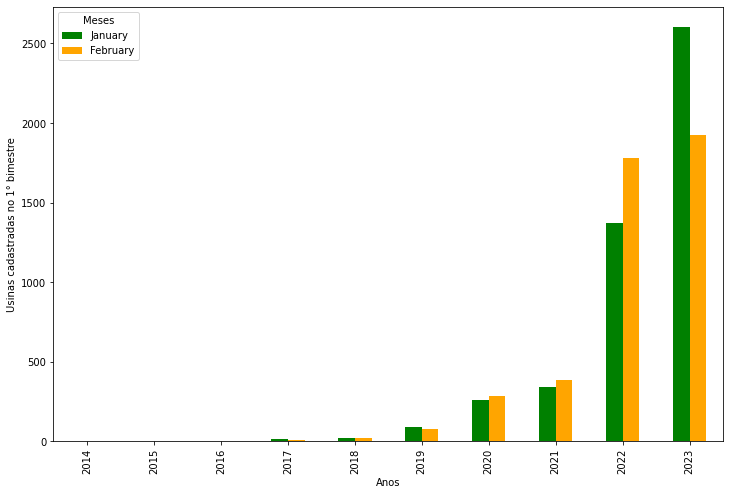

In [11]:
bar_plot2(data_GD, list_1b).show()

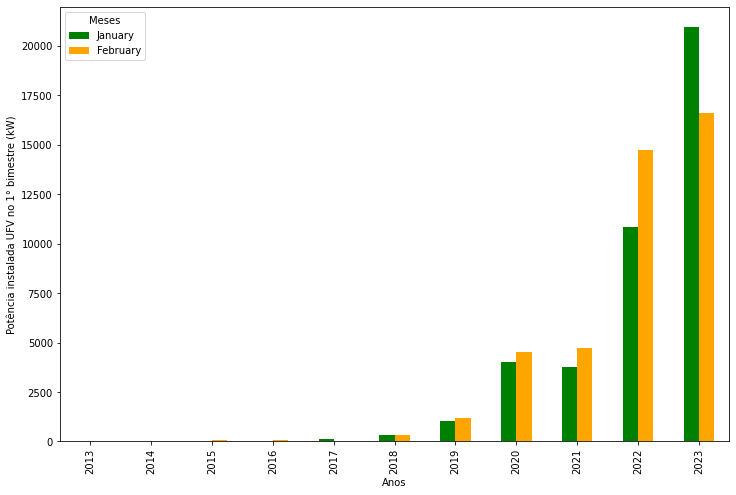

In [12]:
bar_plot(data_GD, list_1b).show()

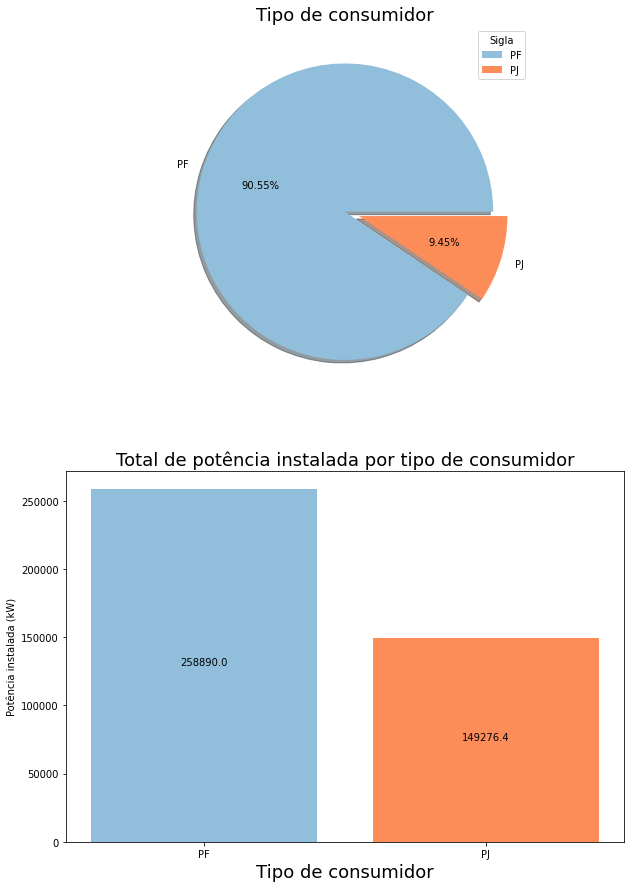

In [13]:
sub_pie_bar(data_GD).show()